In [1]:
!ls -lh /mnt/clp-k8s-fpga-worker-1/pcap/output/*.npy

-rw-r--r-- 1 jovyan jovyan 22M Mar 22 08:42 /mnt/clp-k8s-fpga-worker-1/pcap/output/20240321_152920_itc_corr.1.sdp.pcap.npy
-rw-r--r-- 1 jovyan jovyan 22M Mar 22 08:42 /mnt/clp-k8s-fpga-worker-1/pcap/output/20240322_072551_itc_corr.1.sdp.pcap.npy
-rw-r--r-- 1 jovyan jovyan 12M Mar 22 09:23 /mnt/clp-k8s-fpga-worker-1/pcap/output/20240322_091633_twotones_H_noise_V_itc_corr_1.sps.pcap.npy
-rw-r--r-- 1 jovyan jovyan 22M Mar 21 15:43 /mnt/clp-k8s-fpga-worker-1/pcap/output/foo.npy


In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
from os import listdir
from os.path import isfile, join

filepath = "/mnt/clp-k8s-fpga-worker-1/pcap/output"
pcaplist=[]
for file in listdir(filepath):
    if file.endswith("sps.pcap.npy"):
        pcaplist +=[file]
pcaplist.sort()
pcapfiles = [join(filepath, f) for f in pcaplist if isfile(join(filepath, f))]
filename = pcapfiles[-1]
print(filename)

/mnt/clp-k8s-fpga-worker-1/pcap/output/20240322_091633_twotones_H_noise_V_itc_corr_1.sps.pcap.npy


In [4]:
sps = np.load(filename)
print(sps.shape)

(1440, 2048)


In [5]:
n_stations = 5
n_channels = 96
n_packets = int(sps.shape[0]/(n_stations*n_channels))

### Structure of SPS data

[NOF_PACKETS_PER_STATION][NOF_STATIONS][NOF_CHANNELS][2048 timesamples][Vreal, Vimag, Hreal, Himag]

In [6]:
sps=sps.reshape((n_packets, n_stations, n_channels, 2048))
print(sps.shape)

(3, 5, 96, 2048)


In [7]:
vr,vi,hr,hi=sps["Vpol_real"],sps["Vpol_imag"],sps["Hpol_real"],sps["Hpol_imag"]
channel_data = np.zeros((n_packets, n_stations, n_channels, 4))
print(channel_data.shape)
channel_data[:,:,:,0]=np.mean(vr,axis=-1)
channel_data[:,:,:,1]=np.mean(vi,axis=-1)
channel_data[:,:,:,2]=np.mean(hr,axis=-1)
channel_data[:,:,:,3]=np.mean(hi,axis=-1)

(3, 5, 96, 4)


In [8]:
# Convert real,imag dimensions into complex array
#     c_arr = arr[...,0] + arr[...,1] * 1j
v_channels = np.mean(channel_data[:, :, :, 0] + 1j * channel_data[:, :, :, 1], axis=0)
h_channels = np.mean(channel_data[:, :, :, 2] + 1j * channel_data[:, :, :, 3], axis=0)
print(v_channels.shape)
print(h_channels.shape)
channels = range(n_channels)

(5, 96)
(5, 96)


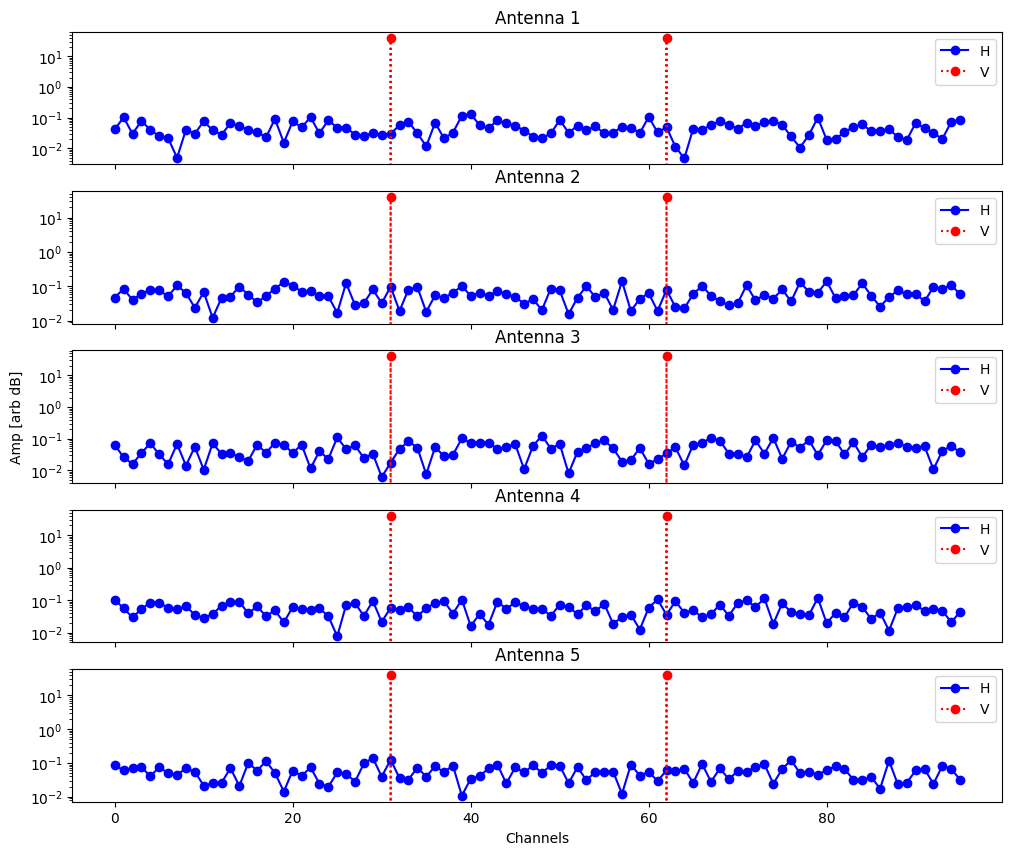

In [9]:
# plot amplitude-
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 10), sharex=True)
for idx in range(n_stations):
    axes[idx].semilogy(channels, np.abs(h_channels[idx,:]), "bo-", label="H")
    axes[idx].semilogy(channels, np.abs(v_channels[idx,:]), "ro:", label="V")
    axes[idx].set_title(f"Antenna {idx+1}")
    axes[idx].legend()
    
axes[n_stations-1].set_xlabel("Channels")
axes[2].set_ylabel('Amp [arb dB]')
plt.show()

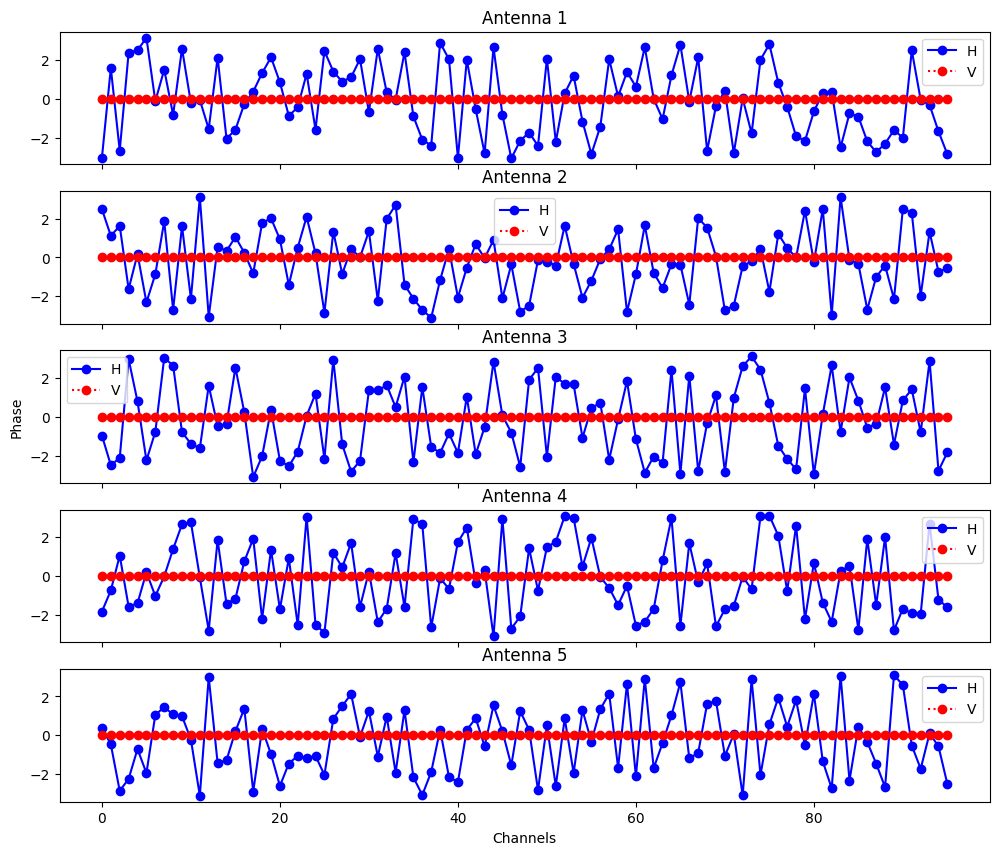

In [10]:
# plot phase-
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 10), sharex=True)
for idx in range(n_stations):
    axes[idx].plot(channels, np.angle(h_channels[idx,:]), "bo-", label="H")
    axes[idx].plot(channels, np.angle(v_channels[idx,:]), "ro:", label="V")
    axes[idx].set_title(f"Antenna {idx+1}")
    axes[idx].legend()
    
axes[n_stations-1].set_xlabel("Channels")
axes[2].set_ylabel('Phase')

plt.show()